In [427]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
import time
import datetime
from unidecode import unidecode
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import pandas as pd
import random
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')
from scipy.spatial import distance

BASE_URL = 'https://www.google.com/flights/explore/'


# add wait method to actionchains class
# http://stackoverflow.com/questions/36572190/specify-wait-time-between-actions-when-using-selenium-actionchains
class ActionChains(ActionChains):
    def wait(self, time_s):
        self._actions.append(lambda: time.sleep(time_s))
        return self


# Task #1
# trick:
# 1. need to update date after input FROM&TO cities. Otherwise it will overwrite the date.
# 2. add sleep time to almost every move in order to make next move until the web is full loaded
def scrape_data(start_date, from_place, to_place, city_name):
    """
    used for initializing the start_date and typing from_place, to_place into the search box.

    :param start_date:
    this is a datetime object for the start date that you should use in your query to Google
    Flight explorer.

    :param from_place:
    this is a string with the name of the origin of the flights

    :param to_place:
    this is a string with the name of the regional destination of the flights, e.g. India, South America,
    Scandinavia This is what would be typed into the To field on the Flight Explorer page.

    :param city_name:
    this is a string for the name of the city who's data that you should actually scrape

    :return:
    selenium driver, and the index of the target city
    """

    driver = webdriver.Chrome('./chromedriver')
    driver.get(BASE_URL)

    time.sleep(4)

    # input from place
    driver.find_elements_by_css_selector('.LJTSM3-p-a')[0].click()
    ActionChains(driver).wait(1).send_keys(from_place).perform()
    ActionChains(driver).wait(1).send_keys(Keys.ENTER).perform()
    # input to place
    driver.find_elements_by_css_selector('.LJTSM3-p-a')[1].click()
    ActionChains(driver).wait(1).send_keys(to_place).perform()
    ActionChains(driver).wait(1).send_keys(Keys.ENTER).perform()

    time.sleep(2)

    start_date_str = start_date.strftime('%Y-%m-%d')
    URL = driver.current_url[:-10] + start_date_str
    driver.get(URL)

    time.sleep(2)

    # manage time difference
    len_of_little_bar = driver.find_elements_by_class_name('LJTSM3-w-x')[0].get_attribute('style').split('height:')[-1].replace(';','').strip()
    if len_of_little_bar == '5px':
        start_date_str = (start_date + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
        URL = driver.current_url[:-10] + start_date_str
        driver.get(URL)
    time.sleep(2)

    # find the location of target city
    cities = driver.find_elements_by_css_selector('.LJTSM3-v-c')
    city_names = [unidecode(n.text) for n in cities]
    n_th = None
    for i, name in enumerate(city_names):
        if city_name.lower() in name.lower():
            n_th = i

    target = driver.find_elements_by_class_name('LJTSM3-v-d')[n_th]
    bars = target.find_elements_by_class_name('LJTSM3-w-x')
    prices = []
    dates = []
    time.sleep(2)

    for bar in bars:
        ActionChains(driver).wait(0.01).move_to_element(bar).perform()
        price = target.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[0].text.replace('$','')
        date = target.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[1].text
        prices.append(price)
        dates.append(date)

    df = pd.DataFrame({'Date_of_Flight':dates,'Price':prices})
    df.Price = df.Price.apply(lambda x: int(x.replace(',','')))
    driver.quit()
    return df


# Task #2
# trick:
# 1. when click to see the rest 30 days, the displayed order of cities will change
# 2. somehow you cannot click the page-down arrow of the city you are scraping, need to click that of another one.
def scrape_data_90(start_date, from_place, to_place, city_name):
    """
    :param start_date: same as above
    :param from_place: same as above
    :param to_place: same as above
    :param city_name: same as above
    :return: a dataframe with 90 rows and with two columns "Date_of_Flight" and "Price."
    """
    driver = webdriver.Chrome('./chromedriver')
    driver.get(BASE_URL)

    time.sleep(4)

    # input from place
    driver.find_elements_by_css_selector('.LJTSM3-p-a')[0].click()
    ActionChains(driver).wait(1).send_keys(from_place).perform()
    ActionChains(driver).wait(1).send_keys(Keys.ENTER).perform()
    # input to place
    driver.find_elements_by_css_selector('.LJTSM3-p-a')[1].click()
    ActionChains(driver).wait(1).send_keys(to_place).perform()
    ActionChains(driver).wait(1).send_keys(Keys.ENTER).perform()

    time.sleep(2)

    start_date_str = start_date.strftime('%Y-%m-%d')
    URL = driver.current_url[:-10] + start_date_str
    driver.get(URL)

    time.sleep(2)

    # manage time difference
    len_of_little_bar = driver.find_elements_by_class_name('LJTSM3-w-x')[0].get_attribute('style').split('height:')[-1].replace(';','').strip()
    if len_of_little_bar == '5px':
        start_date_str = (start_date + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
        URL = driver.current_url[:-10] + start_date_str
        driver.get(URL)
    time.sleep(2)

    # find the location of target city
    cities = driver.find_elements_by_css_selector('.LJTSM3-v-c')
    city_names = [unidecode(n.text) for n in cities]
    n_th = None
    for i, name in enumerate(city_names):
        if city_name.lower() in name.lower():
            n_th = i

    total = len(city_names)

    target = driver.find_elements_by_class_name('LJTSM3-v-d')[n_th]
    bars = target.find_elements_by_class_name('LJTSM3-w-x')
    prices = []
    dates = []
    time.sleep(2)

    for bar in bars:
        ActionChains(driver).wait(0.01).move_to_element(bar).perform()
        price = target.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[0].text.replace('$','')
        date = target.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[1].text
        prices.append(price)
        dates.append(date)

    page_down_botton_index = random.choice([x for x in range(total) if x != n_th])
    time.sleep(2)
    driver.find_elements_by_class_name('LJTSM3-w-D')[page_down_botton_index].click()
    time.sleep(2)
    driver.find_elements_by_class_name('LJTSM3-w-D')[page_down_botton_index].click()
    time.sleep(2)

    # order changed, so again, find the location of target city
    cities = driver.find_elements_by_css_selector('.LJTSM3-v-c')
    city_names = [unidecode(n.text) for n in cities]
    n_th = None
    for i, name in enumerate(city_names):
        if city_name.lower() in name.lower():
            n_th = i
    time.sleep(2)

    target = driver.find_elements_by_class_name('LJTSM3-v-d')[n_th]
    bars = target.find_elements_by_class_name('LJTSM3-w-x')
    for bar in bars[:30]:
        ActionChains(driver).wait(0.01).move_to_element(bar).perform()
        price = driver.find_element_by_class_name('LJTSM3-w-w').text.replace('$','')
        date = driver.find_element_by_class_name('LJTSM3-w-h').text
        prices.append(price)
        dates.append(date)
    df = pd.DataFrame({'Date_of_Flight':dates,'Price':prices})
    df.Price = df.Price.apply(lambda x: int(x.replace(',','')))
    driver.quit()
    return df

# task #3 part 1
def task_3_dbscan(flight_data):
    """
    :param flight_data: a datefrome
    :return: a dateframe
    """
    df = flight_data
    start_date = parse(df.Date_of_Flight[0].split('-')[0].strip())

    df.Date_of_Flight = df.Date_of_Flight.apply(lambda x: (parse(x.split('-')[0].strip())- parse(df.Date_of_Flight[0].split('-')[0].strip())).days+1)

    X = StandardScaler().fit_transform(df[['Date_of_Flight', 'Price']])
    db = DBSCAN(eps=.3, min_samples=6).fit(X)

    labels = db.labels_
    clusters = len(set(labels))
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    plt.subplots(figsize=(12,8))

    for k, c in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=c,
                markeredgecolor='k', markersize=14)

    plt.title("Total Clusters: {}".format(clusters), fontsize=14, y=1.01)

    plt.savefig('task_3_dbscan.png')

    df['dbscan_labels'] = db.labels_

    # find closest cluster
    df_encoded = pd.DataFrame(np.concatenate((X,db.labels_.reshape(-1,1)),axis=1))
    df_encoded.columns = ['Date_of_Flight','Price','dbscan_labels']
    df_encoded.head(5)
    df_agged = df_encoded.groupby('dbscan_labels')['Date_of_Flight','Price'].agg(['min','mean','count']).copy()

    lowest_in_outliers = (df_encoded.Date_of_Flight[df_encoded.Price == df_agged.Price.iloc[0,0]].values[0],
                          df_agged.Price.iloc[0,0])

    x = df_agged.Date_of_Flight.iloc[1:,1].tolist()
    y = df_agged.Price.iloc[1:,1].tolist()
    mean_clusters = [(x,y) for x,y in zip(x,y)]
    min_cluster_index = 0
    min_dist = 9999
    for i, mean_point in enumerate(mean_clusters):
        dist = distance.euclidean(lowest_in_outliers,mean_point)
        if dist < min_dist:
            min_dist = dist
            min_cluster_index = i

    # threshold of the closest cluster
    df_closest = df[df.dbscan_labels == min_cluster_index]
    std = np.std(df_closest.Price)
    mean = np.mean(df_closest.Price)

    thrhd = max(mean - 2 * std, 50)
    df_outliers = df[df.dbscan_labels == -1].copy()
    lowest_outlier = df_outliers[df_outliers.Price == df_outliers.Price.min()]

    if lowest_outlier.Price.values[0] < thrhd:
        lowest_outlier.Date_of_Flight = lowest_outlier.Date_of_Flight.apply(lambda x:(start_date+datetime.timedelta(
            days=x-1)).strftime('%Y-%m-%d'))
        return lowest_outlier[['Date_of_Flight','Price']].reset_index(drop=True)
    else:
        return 'No good flight price'


# task #3 part 2
# tho, i don't think this will be useful
def task_3_IQR(flgiht_data):
    df = flgiht_data
    plt.boxplot(df.Price);
    plt.title('Boxplot')
    plt.savefig('task_3_iqr.png')
    Q3 = df.Price.describe()['75%']
    Q1 = df.Price.describe()['25%']
    IQR = Q3 - Q1
    low_bound = Q1 - 1.5 * IQR
    rslt = df[df.Price < low_bound]
    if rslt.shape[0] != 0:
        return rslt
    else:
        return 'No good flight price'


# task #3 part 3
def task_3_ec(flight_data):
    df = flight_data
    pass

def task_4_dbscan(flight_data):
    df = flight_data




In [525]:
df = scrape_data_90(datetime.datetime.now(), 'nyc', 'united states', 'buffalo')

In [531]:
df.head()

,Date_of_Flight,Price
0,1,283
1,2,365
2,3,278
3,4,248
4,5,248


In [527]:
df.Date_of_Flight = df.Date_of_Flight.apply(lambda x: (parse(x.split('-')[0].strip())- parse(df.Date_of_Flight[0].split('-')[0].strip())).days+1)

In [545]:
df = df[['Date_of_Flight','Price']]

In [546]:
df.head()

,Date_of_Flight,Price
0,1,283
1,2,365
2,3,278
3,4,248
4,5,248


In [547]:
scale = np.sqrt(20 ** 2 / 3)
scale = math.ceil(scale * 100) / 100
radius = np.sqrt(np.square(20) + np.square(scale))
X = df.values
X = X * np.array([scale,1])
db = DBSCAN(eps=radius, min_samples=3).fit(X)
df['label'] = db.labels_

In [548]:
db.labels_

array([-1, -1, -1,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, -1,  2,  2,
        2,  2,  2,  2, -1,  3,  3,  3,  3,  4,  4, -1,  4,  4,  4,  4,  4,
       -1, -1,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, -1, -1,  6,
        6,  6,  6,  6, -1, -1, -1, -1,  7,  7,  7, -1, -1,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10])

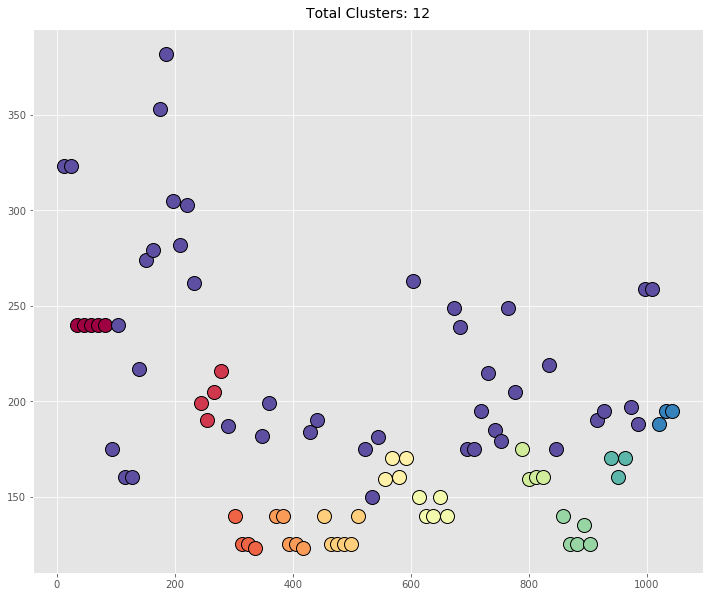

In [533]:
db = DBSCAN(eps=radius,min_samples=3).fit(X)
labels = db.labels_
clusters = len(set(labels))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.subplots(figsize=(12,10))

for k, c in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=c,
            markeredgecolor='k', markersize=14)

plt.title("Total Clusters: {}".format(clusters), fontsize=14, y=1.01)
df['label'] = db.labels_

In [534]:
df.groupby('label')['Price'].agg(['mean','count'])

,mean,count
label,,
-1,178.333333,42
0,254.000000,5
1,186.750000,4
2,166.750000,4
3,143.000000,5
4,134.666667,6
5,155.500000,4
6,156.400000,5
7,133.000000,4


In [535]:
one_cluster = df[df.label == 0]
one_cluster.loc[2:6, ['Date_of_Flight','Price']]

,Date_of_Flight,Price
2,3,278
3,4,248
4,5,248
5,6,248
6,7,248


In [503]:
start_date = datetime.datetime.now()

In [541]:
list_of_dfs = []
for label in unique_labels:
    if label != -1:
        one_cluster = df[df.label == label]

        # find start/end date for every 5-day-consecutive period
        consecutive_list = []
        days = one_cluster.Date_of_Flight.values
        for i in range(len(days) - 4):
            if days[i + 4] - days[i] == 4:
                consecutive_list.append((days[i], days[i + 4]))

        # a list of 5-day-consecutive period dataframes
        for start, end in consecutive_list:
            df_five_day = one_cluster.loc[start -1:end-1, ['Date_of_Flight','Price']]

            if df_five_day.Price.describe()['max'] - df_five_day.Price.describe()['min'] <= 20:
                
                df_five_day.Date_of_Flight = df_five_day.Date_of_Flight.apply(
                        lambda x: (start_date + datetime.timedelta(
                            days=x - 1)).strftime('%Y-%m-%d'))
                list_of_dfs.append(df_five_day)
means = [one_df.Price.mean() for one_df in list_of_dfs]
df_min_index = means.index(min(means))
list_of_dfs[df_min_index]

ValueError: min() arg is an empty sequence

In [423]:
df_min_index

0

In [28]:
%matplotlib inline